# Cardiac Detection

In [1]:
!pip install pydicom

from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.4 MB/s eta 0:00:00


In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hitoshisato96","key":"b720f2ad2751c868cd139086c357c636"}'}

In [4]:
!pip install kaggle -q

In [5]:
!mkdir -p ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [03:04<00:00, 23.1MB/s]
100% 3.66G/3.66G [03:04<00:00, 21.3MB/s]


In [9]:
!unzip /content/rsna-pneumonia-detection-challenge.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stag

In [10]:
# Criação da pasta que irá conter os dados (train/test).
from pathlib import Path

# Criar diretório que irá receber os dados "Data".
data_path = Path("data/")

# Criar o diretório para receber as imagens
image_path = data_path / "datasets"

# Verificar se o diretório já existe, se não criar um.
if image_path.is_dir():
  print(f"O diretório {image_path} ja existe, pule para o download dos dados...")
else:
  print(f"O diretório {image_path} não existe, criando....")
  image_path.mkdir(parents=True, exist_ok=True)
  print("Diretório criado com sucesso!")

O diretório data/datasets não existe, criando....
Diretório criado com sucesso!


In [11]:
import shutil
import zipfile
import os
from google.colab import drive
drive.mount('/content/drive')

# Criar um caminho para o arquivo
origem = '/content/drive/MyDrive/Colab Notebooks/Image_Medical/Seção/Seção 9/05-Detection.zip'

# Caminho que o arquivo irá ser armazenado
destino = image_path / "datasets.zip"

# Copiar o arquivo para a pasta
shutil.copy(origem, destino)
print("Copiado com sucesso!")

# Unzip
with zipfile.ZipFile(image_path / "datasets.zip", "r") as zip_ref:
  print("Descompactando o arquivo.....")
  zip_ref.extractall(image_path)
  os.remove(image_path / "datasets.zip")
  print("Arquivo descompactado com sucesso!")

# Apagar a pasta do drive.
drive.flush_and_unmount()

Mounted at /content/drive
Copiado com sucesso!
Descompactando o arquivo.....
Arquivo descompactado com sucesso!


In [12]:
labels = pd.read_csv("/content/data/datasets/05-Detection/rsna_heart_detection.csv")

In [13]:
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [14]:
data_path = '/content/data/datasets/05-Detection'
data_path

'/content/data/datasets/05-Detection'

In [15]:
ROOTH_PATH = Path("/content/stage_2_train_images")
SAVE_PATH = Path("Processed-Heart-Detection")
ROOTH_PATH, SAVE_PATH

(PosixPath('/content/stage_2_train_images'),
 PosixPath('Processed-Heart-Detection'))

**Nota: Esse código processa imagens DICOM, redimensiona-as, e desenha regiões de interesse (ROI) destacadas em vermelho em uma grade de 2x2. Cada subimagem é mostrada com uma coloração em tons de cinza (cmap="bone").**

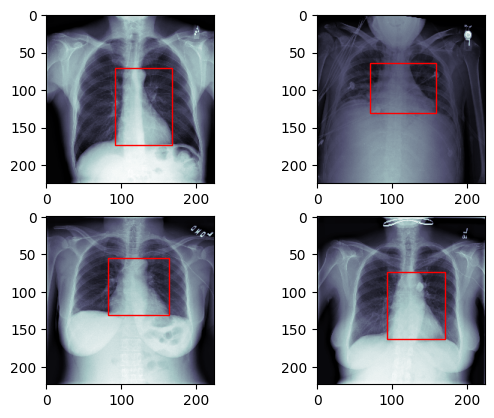

In [16]:
# Cria uma figura e uma matriz de eixos (2x2) para exibir múltiplas imagens
fig, axis = plt.subplots(2, 2)

# Inicializa um contador para percorrer as imagens e os dados
c = 0

# Loop para percorrer as linhas da matriz de eixos (2 linhas)
for i in range(2):
    # Loop para percorrer as colunas da matriz de eixos (2 colunas)
    for j in range(2):
        # Obtém a linha correspondente dos dados de 'labels' usando o contador 'c'
        data = labels.iloc[c]

        # Obtém o nome do paciente a partir dos dados
        patient_id = data["name"]

        # Constrói o caminho completo do arquivo DICOM usando o ID do paciente
        dcm_path = ROOTH_PATH / str(patient_id)
        # Altera a extensão do arquivo para ".dcm" (usada para arquivos DICOM)
        dcm_path = dcm_path.with_suffix(".dcm")

        # Lê o arquivo DICOM usando a biblioteca pydicom
        dcm = pydicom.dcmread(dcm_path)

        # Extrai o array de pixels da imagem DICOM
        dcm_array = dcm.pixel_array
        # Redimensiona a imagem para 224x224 pixels usando OpenCV
        dcm_array = cv2.resize(dcm_array, (224, 224))

        # Obtém as coordenadas e dimensões do retângulo de interesse a partir dos dados
        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]

        # Exibe a imagem DICOM no eixo correspondente, usando um mapa de cores estilo "bone"
        axis[i][j].imshow(dcm_array, cmap="bone")

        # Cria um retângulo para destacar a região de interesse (ROI) na imagem
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor="r", facecolor="none")
        # Adiciona o retângulo ao eixo atual
        axis[i][j].add_patch(rect)

        # Incrementa o contador para passar à próxima imagem
        c += 1

In [17]:
# Inicializa variáveis para armazenar a soma dos pixels e a soma dos quadrados dos pixels para normalização
sums, sums_squared = 0, 0

# Inicializa listas para armazenar os IDs dos pacientes para os conjuntos de treino e validação
train_ids = []
val_ids = []

# Itera sobre os IDs dos pacientes e seus índices usando enumerate
for counter, patient_id in enumerate(list(labels.name)):
    # Constrói o caminho do arquivo DICOM usando o ID do paciente
    dcm_path = ROOTH_PATH / str(patient_id)
    # Altera a extensão do arquivo para ".dcm" (usada para arquivos DICOM)
    dcm_path = dcm_path.with_suffix(".dcm")

    # Lê o arquivo DICOM usando a biblioteca pydicom
    dcm = pydicom.dcmread(dcm_path)

    # Extrai o array de pixels da imagem DICOM
    dcm_array = dcm.pixel_array
    # Redimensiona a imagem para 224x224 pixels e normaliza os valores para o intervalo [0, 1], convertendo para float16
    dcm_array = (cv2.resize(dcm_array, (224, 224)) / 255).astype(np.float16)

    # Define se a imagem atual será usada para treino ou validação, com as primeiras 400 sendo de treino
    train_or_val = "train" if counter < 400 else "val"

    # Adiciona o ID do paciente à lista correspondente (treino ou validação)
    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)

    # Define o caminho para salvar a imagem normalizada, de acordo com o tipo (treino/validação)
    current_save_path = SAVE_PATH / train_or_val
    # Cria o diretório de destino, se ainda não existir
    current_save_path.mkdir(parents=True, exist_ok=True)

    # Salva o array da imagem como um arquivo .npy (NumPy) no caminho especificado
    np.save(current_save_path / patient_id, dcm_array)

    # Define um fator de normalização baseado no tamanho da imagem (224 * 224)
    normalizer = 224 * 224

    # Atualiza as somas para normalização apenas para as imagens de treino
    if train_or_val == "train":
        # Adiciona à soma total a média dos valores de pixel da imagem atual
        sums += np.sum(dcm_array) / normalizer
        # Adiciona à soma dos quadrados a média dos quadrados dos valores de pixel da imagem atual
        sums_squared += (dcm_array ** 2).sum() / normalizer

In [18]:
np.save("Processed-Heart-Detection/train_subjects", train_ids)
np.save("Processed-Heart-Detection/val_subjects", val_ids)

In [19]:
mean = sums / len(train_ids)
std = np.sqrt((sums_squared / len(train_ids)) - mean**2)

In [20]:
mean, std

(0.49430165816326493, 0.2527964897943661)

## Dataset

In [21]:
!pip install imgaug

In [22]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

Esse código define uma classe CardiacDataset que facilita o carregamento de dados de imagens e bounding boxes para treinamento de uma rede neural convolucional (CNN). Ele realiza o pré-processamento dos dados, aplica aumentações de imagens (caso estejam definidas), e normaliza as imagens antes de retorná-las.

In [23]:
# Definição da classe CardiacDataset, que herda de torch.utils.data.Dataset
class CardiacDataset(torch.utils.data.Dataset):

    # Método de inicialização, recebe o caminho para o CSV de labels, os IDs dos pacientes, o caminho raiz das imagens e as aumentações.
    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        # Carrega o CSV contendo as labels (informações de bounding boxes)
        self.labels = pd.read_csv(path_to_labels_csv)
        # Carrega a lista de IDs dos pacientes de um arquivo .npy
        self.patients = np.load(patients)
        # Define o caminho raiz onde as imagens dos pacientes estão armazenadas
        self.root_path = Path(root_path)
        # Define as transformações de aumentação a serem aplicadas nas imagens
        self.augment = augs

    # Retorna o número total de pacientes no dataset
    def __len__(self):
        return len(self.patients)

    # Recupera a imagem e o bounding box correspondente ao índice especificado
    def __getitem__(self, idx):
        # Obtém o ID do paciente correspondente ao índice
        patient = self.patients[idx]
        # Filtra as labels para obter os dados do paciente atual
        data = self.labels[self.labels["name"] == patient]

        # Extrai as coordenadas do bounding box (x_min, y_min, x_max, y_max)
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # Calcula x_max com base na largura (w)
        y_max = y_min + data["h"].item()  # Calcula y_max com base na altura (h)
        bbox = [x_min, y_min, x_max, y_max]  # Cria uma lista com as coordenadas do bounding box

        # Constrói o caminho do arquivo .npy da imagem usando o ID do paciente
        file_path = self.root_path / patient
        # Carrega a imagem salva em formato .npy e a converte para float32
        img = np.load(f"{file_path}.npy").astype(np.float32)

        # Verifica se a aumentação está ativada
        if self.augment:
            # Cria um objeto BoundingBox usando as coordenadas extraídas anteriormente
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            # Define uma semente aleatória para garantir reprodutibilidade nas aumentações
            random_seed = torch.randint(0, 100000, (1,)).item()
            imgaug.seed(random_seed)

            # Aplica as transformações de aumentação na imagem e no bounding box
            img, aug_bbox = self.augment(image=img, bounding_boxes=bb)
            # Atualiza o bounding box com as novas coordenadas após a aumentação
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]

        # Normaliza a imagem usando média (0.494) e desvio padrão (0.252)
        img = (img - 0.494) / 0.252
        # Converte a imagem para um tensor PyTorch e adiciona uma dimensão de canal (para indicar que é uma imagem de 1 canal)
        img = torch.tensor(img).unsqueeze(0)
        # Converte o bounding box para um tensor PyTorch
        bbox = torch.tensor(bbox)
        # Retorna a imagem normalizada e o bounding box
        return img, bbox


In [24]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Esse código define uma sequência de aumentações para ser aplicada nas imagens. As transformações incluem ajuste de contraste, redimensionamento, rotação e movimentação das imagens, o que ajuda a aumentar a variabilidade dos dados e, consequentemente, a robustez do modelo de aprendizado profundo durante o treinamento.

In [25]:
# Cria uma sequência de aumentações de imagem usando a classe Sequential do imgaug
seq = iaa.Sequential([
    # Aplica uma correção de contraste usando a transformação GammaContrast.
    # Isso ajusta o brilho das regiões claras e escuras da imagem.
    iaa.GammaContrast(),

    # Aplica transformações geométricas usando a classe Affine.
    iaa.Affine(
        # Altera o tamanho da imagem com um fator de escala aleatório entre 0.8 e 1.2.
        # Um valor menor que 1 reduz a imagem e um valor maior que 1 a aumenta.
        scale=(0.8, 1.2),

        # Rotaciona a imagem aleatoriamente entre -10 e 10 graus.
        # Ajuda a criar variações leves na orientação das imagens.
        rotate=(-10, 10),

        # Translada a imagem (move) horizontal e verticalmente em um intervalo de -10 a 10 pixels.
        # Cria variações na posição dos objetos na imagem.
        translate_px=(-10, 10)
    )
])

In [26]:
labels_path ="/content/data/datasets/05-Detection/rsna_heart_detection.csv"
patients_path = "/content/Processed-Heart-Detection/train_subjects.npy"
train_root = "/content/Processed-Heart-Detection/train"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

Esse código tem como objetivo exibir uma imagem do dataset junto com o bounding box correspondente, que destaca a área de interesse na imagem (por exemplo, uma região de interesse em um exame médico). A visualização ajuda a validar se as coordenadas do bounding box estão corretas e se a aumentação foi aplicada adequadamente.

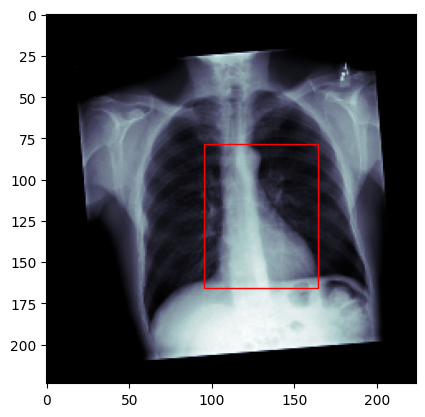

In [27]:
# Obtém a imagem e o bounding box correspondente ao primeiro paciente do dataset
img, bbox = dataset[0]

# Cria uma figura e um eixo para plotar a imagem
fig, axis = plt.subplots(1, 1)

# Exibe a imagem no eixo, usando o colormap "bone" para uma representação adequada de imagens médicas
axis.imshow(img[0], cmap="bone")

# Cria um retângulo (bounding box) usando as coordenadas do bounding box
# bbox[0] e bbox[1] são as coordenadas do canto superior esquerdo (x_min, y_min)
# bbox[2] e bbox[3] são as coordenadas do canto inferior direito (x_max, y_max)
# A largura do retângulo é calculada como bbox[2] - bbox[0] e a altura como bbox[3] - bbox[1]
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], edgecolor="r", facecolor="none")

# Adiciona o retângulo ao eixo, permitindo visualizar a localização do bounding box na imagem
axis.add_patch(rect);

## Train Data loading

In [28]:
import os

# Define o caminho do diretório onde você deseja salvar o arquivo
directory = "/content/Processed-Heart-Detection"

# Cria o diretório, se não existir
os.makedirs(directory, exist_ok=True)

# Define o nome do arquivo que será criado no diretório especificado
file_name = os.path.join(directory, "dataset.py")

# Código que será escrito no arquivo
code = """
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

class CardiacDataset(torch.utils.data.Dataset):
    # Método de inicialização, recebe o caminho para o CSV de labels, os IDs dos pacientes, o caminho raiz das imagens e as aumentações.
    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        # Carrega o CSV contendo as labels (informações de bounding boxes)
        self.labels = pd.read_csv(path_to_labels_csv)
        # Carrega a lista de IDs dos pacientes de um arquivo .npy
        self.patients = np.load(patients)
        # Define o caminho raiz onde as imagens dos pacientes estão armazenadas
        self.root_path = Path(root_path)
        # Define as transformações de aumentação a serem aplicadas nas imagens
        self.augment = augs

    # Retorna o número total de pacientes no dataset
    def __len__(self):
        return len(self.patients)

    # Recupera a imagem e o bounding box correspondente ao índice especificado
    def __getitem__(self, idx):
        # Obtém o ID do paciente correspondente ao índice
        patient = self.patients[idx]
        # Filtra as labels para obter os dados do paciente atual
        data = self.labels[self.labels["name"] == patient]

        # Extrai as coordenadas do bounding box (x_min, y_min, x_max, y_max)
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # Calcula x_max com base na largura (w)
        y_max = y_min + data["h"].item()  # Calcula y_max com base na altura (h)
        bbox = [x_min, y_min, x_max, y_max]  # Cria uma lista com as coordenadas do bounding box

        # Constrói o caminho do arquivo .npy da imagem usando o ID do paciente
        file_path = self.root_path / patient
        # Carrega a imagem salva em formato .npy e a converte para float32
        img = np.load(f"{file_path}.npy").astype(np.float32)

        # Verifica se a aumentação está ativada
        if self.augment:
            # Cria um objeto BoundingBox usando as coordenadas extraídas anteriormente
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            # Define uma semente aleatória para garantir reprodutibilidade nas aumentações
            random_seed = torch.randint(0, 100000, (1,)).item()
            imgaug.seed(random_seed)

            # Aplica as transformações de aumentação na imagem e no bounding box
            img, aug_bbox = self.augment(image=img, bounding_boxes=bb)
            # Atualiza o bounding box com as novas coordenadas após a aumentação
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]

        # Normaliza a imagem usando média (0.494) e desvio padrão (0.252)
        img = (img - 0.494) / 0.252
        # Converte a imagem para um tensor PyTorch e adiciona uma dimensão de canal (para indicar que é uma imagem de 1 canal)
        img = torch.tensor(img).unsqueeze(0)
        # Converte o bounding box para um tensor PyTorch
        bbox = torch.tensor(bbox)
        # Retorna a imagem normalizada e o bounding box
        return img, bbox
"""

# Grava o código no arquivo .py
with open(file_name, "w") as f:
    f.write(code)

# Confirma que o arquivo foi criado
print(f"Arquivo {file_name} criado com sucesso.")


Arquivo /content/Processed-Heart-Detection/dataset.py criado com sucesso.


In [29]:
!pip install lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 52.2 MB/s eta 0:00:00


In [30]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import imgaug.augmenters as iaa

import sys
sys.path.append('/content/Processed-Heart-Detection')
from dataset import CardiacDataset

In [99]:
train_root_path = "/content/Processed-Heart-Detection/train"
train_subjects = "/content/Processed-Heart-Detection/train_subjects.npy"
val_root_path = "/content/Processed-Heart-Detection/val"
val_subjects = "/content/Processed-Heart-Detection/val_subjects.npy"

train_transforms = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale=(0.8, 1.2),
        rotate=(-10, 10),
        translate_px=(-10,10))
])

In [100]:
train_dataset = CardiacDataset("/content/data/datasets/05-Detection/rsna_heart_detection.csv", train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset("/content/data/datasets/05-Detection/rsna_heart_detection.csv", val_subjects, val_root_path, None)

In [101]:
import os
batch_size = 8
num_workers = os.cpu_count()

print(f"Número de CPUs disponíveis: {num_workers}")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Número de CPUs disponíveis: 2


Comentários sobre o código:

**__init__: **A função de inicialização da classe. Define a arquitetura da rede, otimizador, e função de perda.

O modelo é uma versão modificada da ResNet18, ajustada para imagens de canal único (ex: imagens de raios-X).

A última camada foi ajustada para prever 4 valores (provavelmente as coordenadas de uma bounding box).
forward: Esta função faz o processamento direto dos dados pelo modelo. As imagens são passadas pelo modelo para gerar predições.

**training_step:** Função responsável por realizar o passo de treinamento em cada batch. Calcula a perda com base nas predições e rótulos, e também loga as imagens preditas e as perdas.

**log_images:** Loga imagens para visualização no TensorBoard. Inclui predições e as bounding boxes reais desenhadas nas imagens. A cada 50 batches, o modelo desenha as caixas em algumas imagens de amostra e as loga para que possam ser visualizadas.

**configure_optimizers: **Configura o otimizador que será usado durante o treinamento (neste caso, Adam).

In [102]:
import pytorch_lightning as pl
import torch
import torchvision
import numpy as np
import cv2
import torchvision.models as models

class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # Carrega o modelo ResNet18 pré-treinado da torchvision.
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modifica a primeira camada convolucional para lidar com imagens de canal único (1 canal em vez de 3)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Altera a última camada para prever 4 valores (ex: coordenadas de uma bounding box).
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)

        # Define o otimizador como Adam, com uma taxa de aprendizado de 1e-4.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        # Função de perda, neste caso, o Erro Quadrático Médio (MSE).
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        # O batch contém as imagens de raios-X e os respectivos rótulos (coordenadas das bounding boxes).
        x_ray, label = batch
        label = label.float()  # Converte o rótulo para tipo float (reais).

        # Realiza a predição passando as imagens de raios-X pelo modelo.
        pred = self(x_ray)

        # Calcula o erro entre as predições e os rótulos reais usando a função de perda MSE.
        loss = self.loss_fn(pred, label)

        # Registra o valor da perda para monitorar o desempenho durante o treinamento.
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        # A cada 50 batches, loga imagens para acompanhar a evolução das predições visivelmente.
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "train")

        return loss

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Converte o rótulo para tipo float (reais).

        # Realiza a predição
        pred = self(x_ray)

        # Calcula a perda
        loss = self.loss_fn(pred, label)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)  # Log da perda de validação

        # Loga imagens durante a validação, se desejado
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "validation")

        return loss

    def log_images(self, x_ray, pred, label, name):
        results = []  # Lista para armazenar as imagens com as predições desenhadas.

        # Para cada uma das 4 primeiras imagens no batch...
        for i in range(min(4, len(x_ray))):  # Previne erro se o batch tiver menos de 4 imagens
            coords_labels = label[i]  # Coordenadas reais da bounding box (rótulo).
            coords_pred = pred[i]  # Coordenadas preditas da bounding box (previsão).

            # Converte a imagem de raios-X normalizada de volta ao seu espaço original.
            img = ((x_ray[i] * 0.252) + 0.494).numpy()[0]  # Extrai o canal único.

            # Extrai as coordenadas reais das bounding boxes e as converte para inteiros.
            x0, y0 = int(coords_labels[0].item()), int(coords_labels[1].item())
            x1, y1 = int(coords_labels[2].item()), int(coords_labels[3].item())

            # Desenha a bounding box real na imagem.
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)

            # Extrai as coordenadas reais das bounding boxes e as converte para inteiros.
            x0, y0 = int(coords_labels[0].item()), int(coords_labels[1].item())
            x1, y1 = int(coords_labels[2].item()), int(coords_labels[3].item())

            # Desenha a bounding box real na imagem.
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)

            # Adiciona a imagem com a bounding box à lista de resultados.
            results.append(torch.tensor(img).squeeze(0))

        # Cria uma grade de imagens a partir dos resultados.
        grid = torchvision.utils.make_grid(results, nrow=2)

        # Adiciona a grade de imagens ao logger, para ser visualizada no TensorBoard.
        self.logger.experiment.add_image(name, grid, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]


In [103]:
model = CardiacDetectionModel()

Explicação das Configurações

Monitor: O parâmetro monitor deve corresponder ao nome da métrica que você registrou no método validation_step. No exemplo acima, eu mudei de "Val ACC" para "val_acc" para seguir a convenção de nomenclatura (sendo tudo minúsculo e separado por underscore).

Mode: O parâmetro mode deve ser definido como "max" quando você está monitorando a precisão (ou qualquer outra métrica onde um valor mais alto é melhor). Se você estivesse monitorando uma métrica onde um valor menor é melhor (como val_loss), você usaria "min".

save_top_k: Especifica quantos dos melhores modelos devem ser salvos. O exemplo acima salvará os 10 melhores modelos de acordo com a precisão de validação.

filename: Você pode personalizar o formato do nome do arquivo do checkpoint. No exemplo, o nome do arquivo incluirá o número da época e a precisão de validação.

Visualizando os Checkpoints
Os modelos salvos serão armazenados no diretório padrão de trabalho atual, ou se você especificar um diretório ao instanciar o ModelCheckpoint, eles serão salvos nesse diretório. Após o treinamento, você pode carregar o modelo salvo para realizar previsões ou continuar o treinamento.

In [104]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [109]:
# Configurando o callback para salvar checkpoints
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",         # Nome da métrica a ser monitorada
    save_top_k=10,              # Salva os 10 melhores checkpoints
    mode="min",                 # Modo para monitorar (minimizar a perda)
    dirpath="./checkpoints",    # Diretório onde os checkpoints serão salvos
    filename="{epoch:02d}-{val_loss:.2f}"  # Formato do nome do arquivo
)

In [110]:
# Configurando o logger
logger = TensorBoardLogger(save_dir="./logs", name="cardiac_detection")

In [111]:
# Cria uma instância do trainer do PyTorch Lightning para gerenciar o processo de treinamento.
trainer = pl.Trainer(
    accelerator="gpu",  # Define que o treinamento deve utilizar uma GPU para acelerar o processo.
    devices=1,  # Especifica que deve usar apenas 1 GPU.
    logger=logger,  # Passa o objeto logger configurado para registrar métricas e informações do treinamento.
    log_every_n_steps=1,  # Define que as métricas devem ser logadas a cada passo de treinamento (step).
    callbacks=checkpoint_callback,  # Inclui callbacks, como salvar checkpoints do modelo durante o treinamento.
    max_epochs=100  # Define o número máximo de épocas para o treinamento.
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [113]:
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | ResNet  | 11.2 M | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [115]:
import matplotlib

# Verifica se CUDA está disponível e define o dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Carrega o modelo a partir do checkpoint
model = CardiacDetectionModel.load_from_checkpoint("/content/checkpoints/epoch=97-val_loss=30.91.ckpt")

# Coloca o modelo em modo de avaliação
model.eval()

# Envia o modelo para o dispositivo correto (CPU ou GPU)
model.to(device)


CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

`from tqdm.notebook import tqdm`: Importa a biblioteca tqdm, que é utilizada para criar barras de progresso em loops, facilitando a visualização do progresso em notebooks Jupyter.

`preds = [] e labels = []`: Inicializa listas vazias para armazenar as previsões feitas pelo modelo e os rótulos verdadeiros correspondentes.

`with torch.no_grad():` Este contexto é usado para desativar o rastreamento de gradientes, o que economiza memória e acelera os cálculos, já que não precisamos realizar backpropagation durante a inferência.

`for data, label in tqdm(val_dataset):` Itera sobre o conjunto de validação (val_dataset). Cada iteração fornece um lote (data) e seus rótulos correspondentes (label). A barra de progresso tqdm mostra o progresso do loop.

`data.to(device).float().unsqueeze(0):` Move os dados para o dispositivo apropriado (GPU ou CPU), garante que os dados estejam em formato de ponto flutuante e adiciona uma dimensão extra para formar um batch, se necessário.

`pred = model(data)[0].cpu():` Realiza a predição usando o modelo. A predição é feita para o primeiro elemento do resultado (assumindo que o modelo retorna mais de uma saída, mas aqui consideramos apenas a primeira) e a saída é movida para a CPU.

`preds.append(pred) e labels.append(label):` Armazena as previsões e os rótulos na lista correspondente para posterior análise.

`preds = torch.stack(preds) e labels = torch.stack(labels):` Combina as listas de previsões e rótulos em tensores do PyTorch, o que facilita a manipulação e análise posterior.

In [124]:
from tqdm.notebook import tqdm  # Importa a barra de progresso para notebooks.

preds = []  # Lista para armazenar as previsões do modelo.
labels = []  # Lista para armazenar os rótulos verdadeiros.

# Desativa o cálculo do gradiente para economizar memória e aumentar a velocidade durante a predição.
with torch.no_grad():
    # Itera sobre os dados do conjunto de validação (val_dataset).
    for data, label in tqdm(val_dataset):
        # Move os dados para o dispositivo especificado (GPU ou CPU) e altera o tipo para float, adicionando uma dimensão extra.
        data = data.to(device).float().unsqueeze(0)  # Adiciona uma dimensão extra para o batch.

        # Realiza a predição usando o modelo. A predição é feita para o primeiro elemento do resultado (supondo que o modelo retorne um batch).
        pred = model(data)[0].cpu()  # Move a previsão para a CPU.

        # Adiciona a previsão e o rótulo à lista correspondente.
        preds.append(pred)  # Armazena a predição.
        labels.append(label)  # Armazena o rótulo verdadeiro.

# Empilha as previsões e os rótulos em tensores do PyTorch.
preds = torch.stack(preds)  # Combina todas as previsões em um único tensor.
labels = torch.stack(labels)  # Combina todos os rótulos em um único tensor.


  0%|          | 0/96 [00:00<?, ?it/s]

In [125]:
abs(preds-labels).mean(0)

tensor([3.5216, 4.0154, 4.1681, 4.0613])

import matplotlib.pyplot as plt: Importa a biblioteca matplotlib, que é usada para criar gráficos e visualizações.

import matplotlib.patches as patches: Importa a subbiblioteca patches do matplotlib, que permite desenhar formas, como retângulos, sobre os gráficos.

`IDX = 20:` Define um índice (20) que será usado para acessar uma imagem específica do conjunto de validação.

`img, label = val_dataset[IDX]:` Extrai a imagem e seu rótulo correspondente do conjunto de validação usando o índice definido.

`pred = preds[IDX]:` Obtém a predição feita pelo modelo para a imagem no índice especificado.

`fig, axis = plt.subplots(1, 1):` Cria uma nova figura (fig) e um eixo (axis) onde a imagem será plotada. O número 1, 1 significa que haverá uma única subplot.

`axis.imshow(img[0], cmap="bone"):` Exibe a imagem no eixo criado. O img[0] extrai o primeiro canal da imagem (assumindo que é uma imagem de canal único, como uma imagem de raios-X). O mapa de cores "bone" é utilizado para melhorar a visualização de imagens médicas.

`heart = patches.Rectangle(...):` Cria um objeto retângulo que representa a bounding box prevista para a localização do coração. Os parâmetros incluem:

`(pred[0], pred[1]):` coordenadas do canto superior esquerdo do retângulo.

`pred[2] - pred[0]:` largura do retângulo (diferença entre a coordenada direita e a esquerda).

`pred[3] - pred[1]:` altura do retângulo (diferença entre a coordenada inferior e a superior).

`edgecolor="r":` define a cor da borda do retângulo como vermelha.

`facecolor="none":` define que a área interna do retângulo deve ser transparente.

`axis.add_patch(heart):` Adiciona o retângulo da predição ao eixo, sobrepondo-o à imagem original.

`plt.show():` Exibe a figura com a imagem e a predição.

**Visualização do Resultado**

Ao executar esse código, você verá a imagem da raios-X com um retângulo vermelho sobreposto, representando a predição do modelo para a localização do coração. Essa visualização é útil para avaliar a precisão das previsões do modelo em imagens reais.

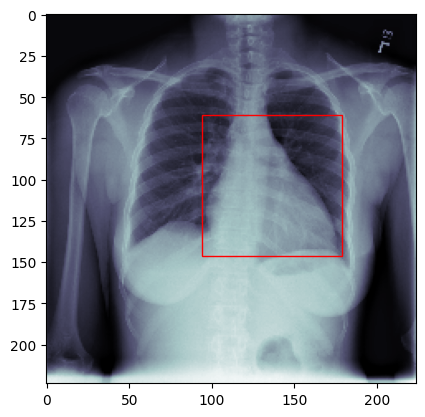

In [127]:
import matplotlib.pyplot as plt  # Importa a biblioteca matplotlib para visualização.
import matplotlib.patches as patches  # Importa a biblioteca de patches para desenhar formas.

# Define o índice da imagem a ser visualizada.
IDX = 20

# Obtém a imagem e o rótulo correspondente do conjunto de validação usando o índice especificado.
img, label = val_dataset[IDX]

# Obtém a predição correspondente a essa imagem do tensor de previsões.
pred = preds[IDX]

# Cria uma figura e um eixo para plotar a imagem.
fig, axis = plt.subplots(1, 1)

# Exibe a imagem de raios-X no eixo, utilizando o mapa de cores "bone" (geralmente utilizado para imagens médicas).
axis.imshow(img[0], cmap="bone")

# Cria um retângulo que representa a predição da bounding box do coração.
# O retângulo é definido pelas coordenadas de início (pred[0], pred[1]) e as dimensões largura (pred[2]-pred[0]) e altura (pred[3]-pred[1]).
heart = patches.Rectangle((pred[0], pred[1]), pred[2] - pred[0], pred[3] - pred[1], edgecolor="r", facecolor="none")

# Adiciona o retângulo da predição ao eixo, permitindo visualizar a predição sobre a imagem.
axis.add_patch(heart)

# Exibe a figura com a imagem e a predição.
plt.show()
